loading annotations into memory...


C:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6225708].


Done (t=0.71s)
creating index...
index created!


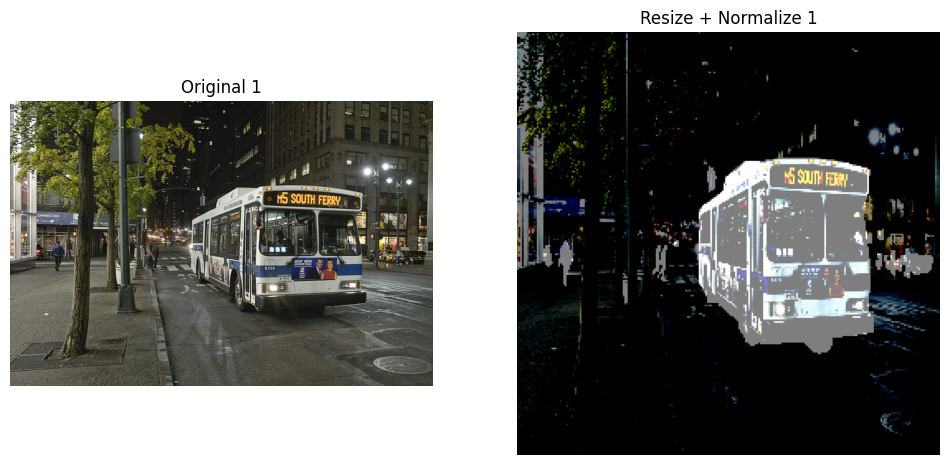

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


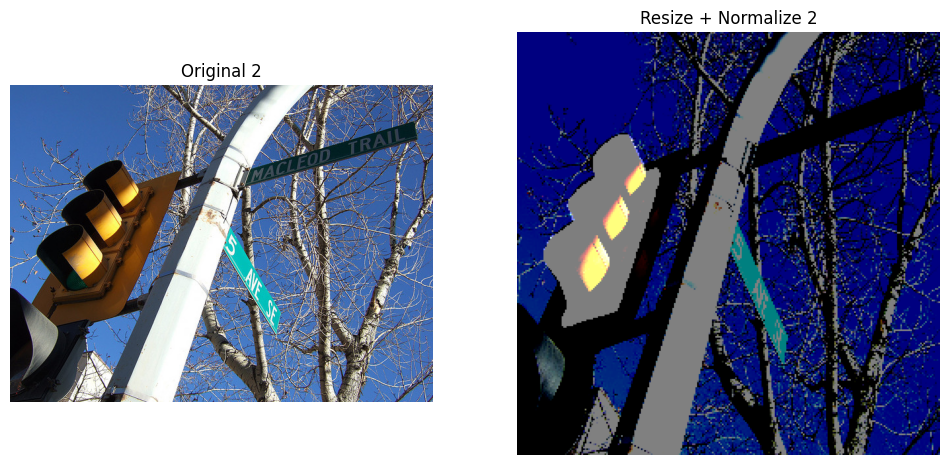

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5877123].


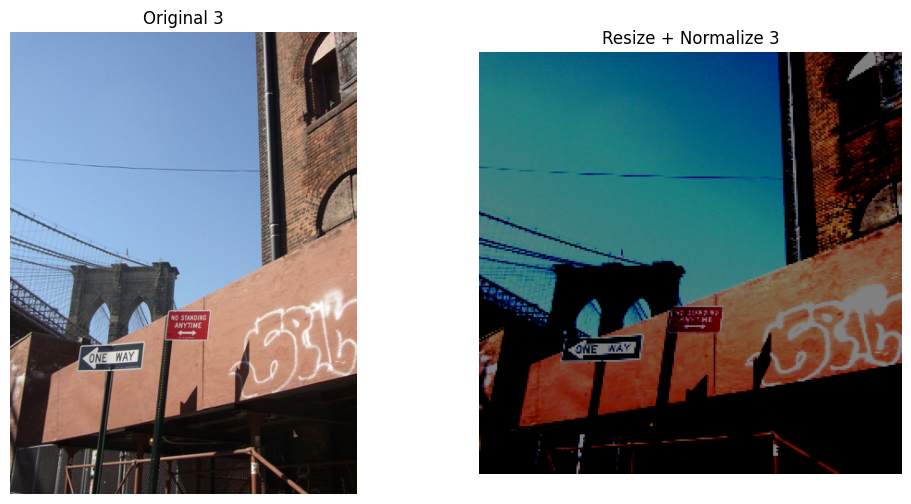

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


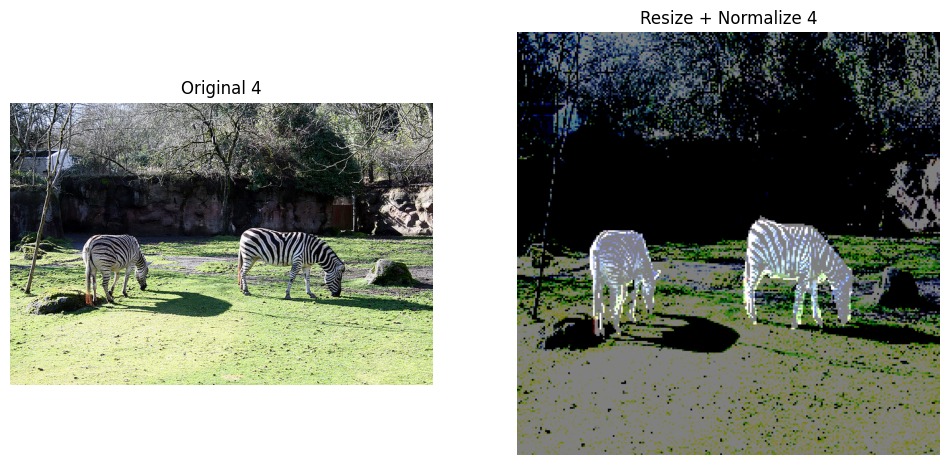

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


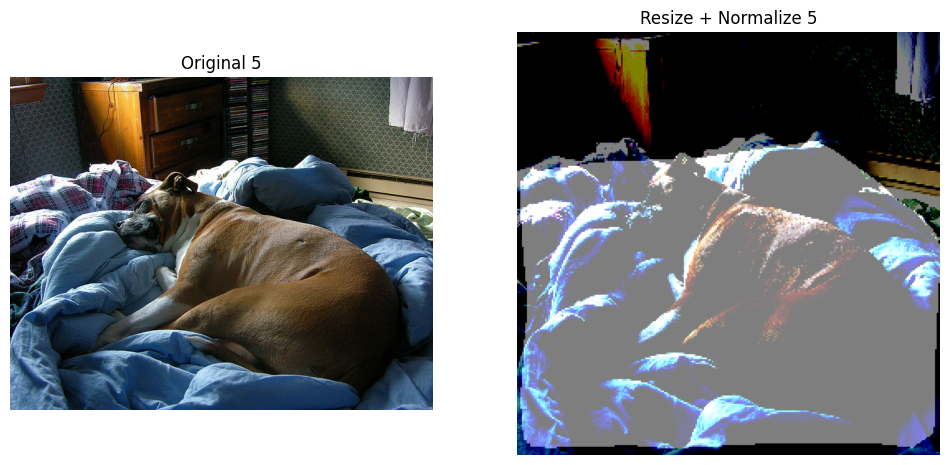

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2787911..2.6399999].


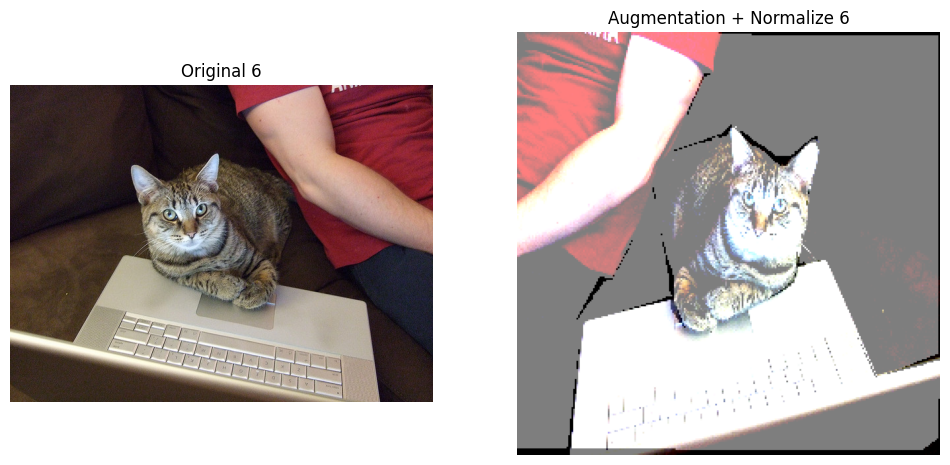

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


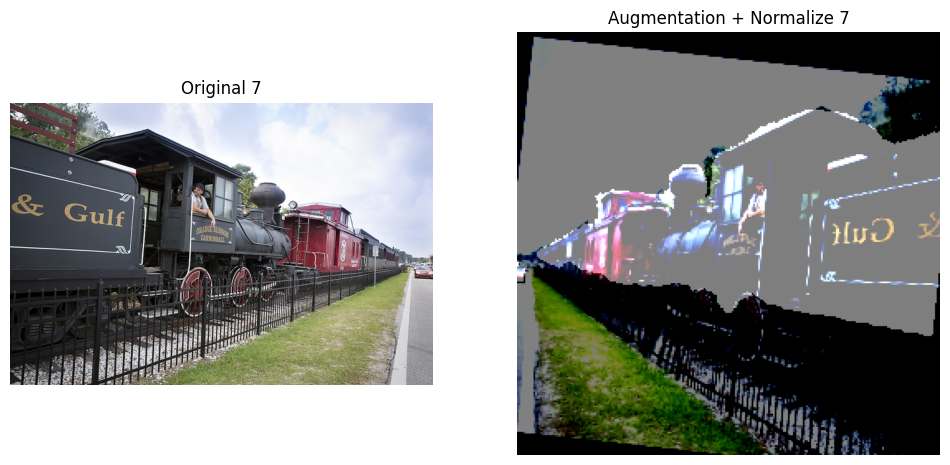

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2616663..2.6399999].


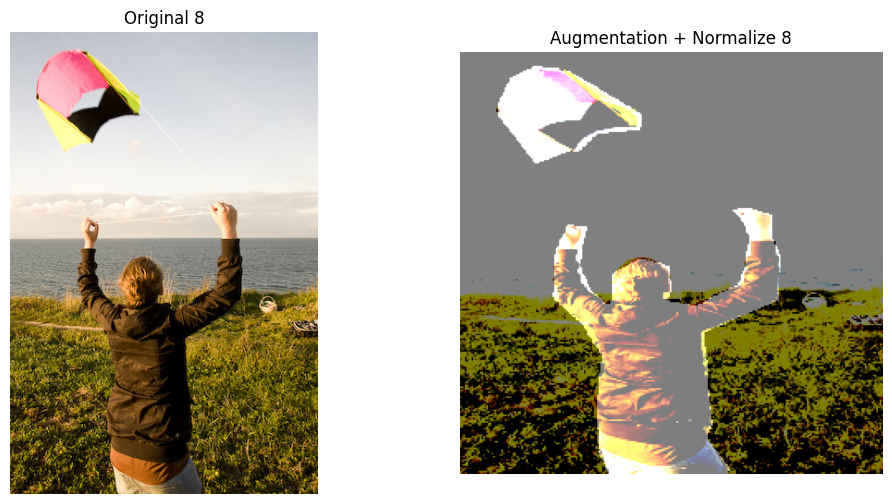

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


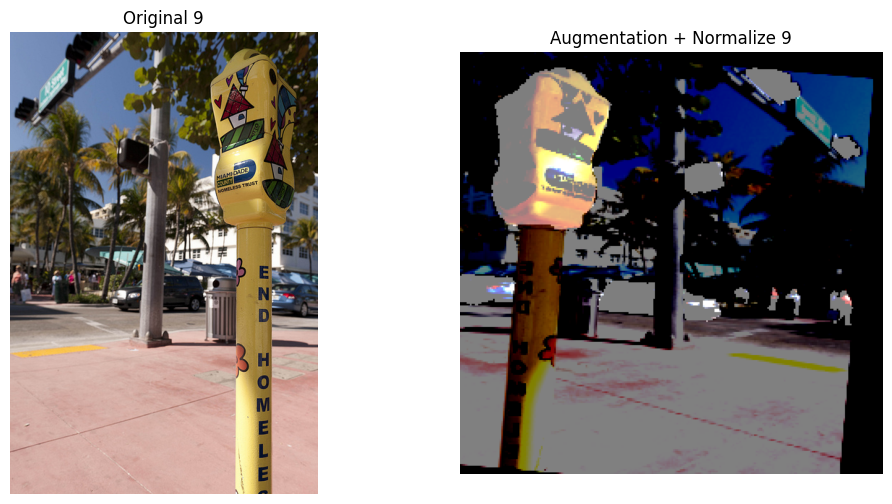

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2959157..2.6399999].


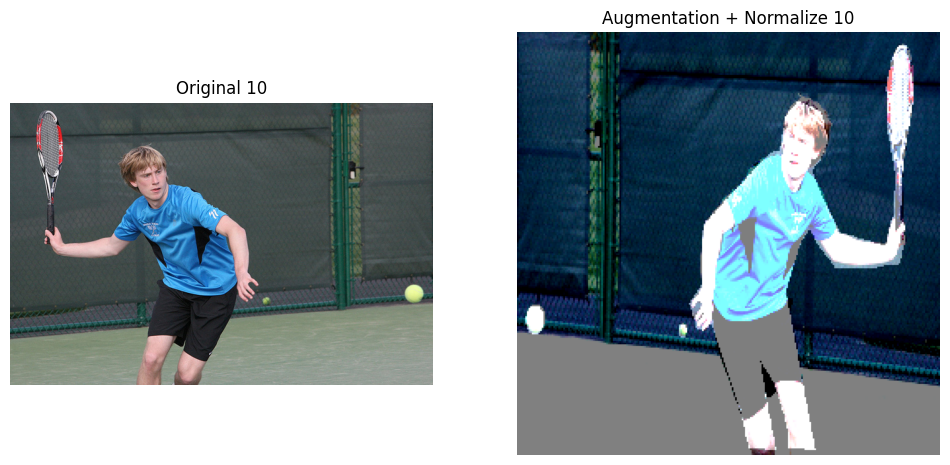

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Path setup
dataDir = r"C:/Users/rahul/Downloads/coco"
dataType = "val2017"
annFile = f"{dataDir}/annotations/instances_{dataType}.json"

# Initialize COCO API
coco = COCO(annFile)

# Get all image IDs
imgIds = coco.getImgIds()

# Select 10 random images
random_ids = random.sample(imgIds, 10)

# ----- Pipelines -----
# 1. Resize + Normalize
resize_norm = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 2. Resize + Augmentation + Normalize
augment = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

for i, imgId in enumerate(random_ids):
    img = coco.loadImgs(imgId)[0]
    I = Image.open(os.path.join(f"{dataDir}/{dataType}", img['file_name'])).convert("RGB")
    I_np = np.array(I)

    # Load annotations
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)

    # Create mask
    mask = np.zeros((img['height'], img['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Apply different pipelines
    if i < 5:  # First 5 → resize + normalize
        transformed = resize_norm(image=I_np, mask=mask)
        mode = "Resize + Normalize"
    else:      # Next 5 → augmentation
        transformed = augment(image=I_np, mask=mask)
        mode = "Augmentation + Normalize"

    img_t = transformed["image"]
    mask_t = transformed["mask"]

    # Convert back for visualization
    img_viz = img_t.permute(1, 2, 0).cpu().numpy()
    mask_viz = mask_t.cpu().numpy()

    # Show results
    plt.figure(figsize=(12,6))

    # Original
    plt.subplot(1,2,1)
    plt.imshow(I_np)
    plt.axis('off')
    plt.title(f"Original {i+1}")

    # Preprocessed
    plt.subplot(1,2,2)
    plt.imshow(img_viz)
    plt.imshow(mask_viz, cmap="gray", alpha=0.5)  # overlay mask
    plt.axis('off')
    plt.title(f"{mode} {i+1}")

    plt.show()
